# Data Preparation

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from Preprocessor import Preprocessor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from sklearn.model_selection import KFold, cross_val_score
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_path = "Dataset/FER2013/train"
test_path = "Dataset/FER2013/test"

In [3]:
EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
num_classes = len(EMOTIONS)

In [4]:
def load_data (data_path):
    # Get emotion categories (folder names)
    categories = sorted(os.listdir(data_path))  # Ensure consistent ordering
    print("Categories:", categories)

    # Map categories to numerical labels
    label_map = {category: idx for idx, category in enumerate(categories)}
    print("Label Map:", label_map)

    images = []
    labels = []
    
    for category, label in label_map.items():
        category_path = os.path.join(data_path, category)
        
        # Load all images in the category folder
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            image = cv2.imread(file_path)
            images.append(image)
            labels.append(label)

    return images, labels

In [5]:
# #combine the data to csv file
# def load_data_to_csv(data_path,file_name):
#     images, labels = load_data(data_path)
#     data = {"images": [img.tolist() for img in images], "emotion": labels}
#     df = pd.DataFrame(data)
#     df.to_csv("Dataset/FER2013/" + file_name, index=False)

In [6]:
# load_data_to_csv(train_path, "train.csv")
# load_data_to_csv(test_path, "test.csv")

In [7]:
# # Load data from CSV files
# train_df = pd.read_csv("Dataset/FER2013/train.csv")
# test_df = pd.read_csv("Dataset/FER2013/test.csv")

In [8]:
images, labels = load_data(train_path)
train_df = pd.DataFrame({
    'image': [img.tolist() for img in images],
    'emotion': labels
})
images, labels = load_data(test_path)
test_df = pd.DataFrame({
    'image': [img.tolist() for img in images],
    'emotion': labels
})

Categories: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Label Map: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


KeyboardInterrupt: 

In [9]:
# #save the data to csv file
# train_df.to_csv("Dataset/FER2013/train.csv", index=False)
# test_df.to_csv("Dataset/FER2013/test.csv", index=False)

In [10]:
print(train_df.head())
print(test_df.head())

                                               image  emotion
0  [[[50, 50, 50], [32, 32, 32], [15, 15, 15], [1...        0
1  [[[29, 29, 29], [24, 24, 24], [29, 29, 29], [1...        0
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...        0
3  [[[155, 155, 155], [138, 138, 138], [98, 98, 9...        0
4  [[[211, 211, 211], [215, 215, 215], [220, 220,...        0
                                               image  emotion
0  [[[46, 46, 46], [34, 34, 34], [26, 26, 26], [2...        0
1  [[[55, 55, 55], [33, 33, 33], [54, 54, 54], [3...        0
2  [[[123, 123, 123], [123, 123, 123], [126, 126,...        0
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...        0
4  [[[127, 127, 127], [121, 121, 121], [124, 124,...        0


In [11]:
print(train_df.count())
print(test_df.count())

image      28709
emotion    28709
dtype: int64
image      7178
emotion    7178
dtype: int64


In [12]:
#count each emotion
emotion_counts = train_df['emotion'].value_counts()
print("Training Data")
print(emotion_counts)

emotion_counts = test_df['emotion'].value_counts()
print("Testing Data")
print(emotion_counts)

Training Data
emotion
3    7215
4    4965
5    4830
2    4097
0    3995
6    3171
1     436
Name: count, dtype: int64
Testing Data
emotion
3    1774
5    1247
4    1233
2    1024
0     958
6     831
1     111
Name: count, dtype: int64


# Preprocess

## Drop Image with Pixel Itensity Equal to 0

In [13]:
#drop images with 0 pixel intensity
train_df = train_df[train_df['image'].map(lambda x: np.max(np.array(x, dtype=np.uint8))) > 0]
test_df = test_df[test_df['image'].map(lambda x: np.max(np.array(x, dtype=np.uint8))) > 0]

print(train_df.count())
print(test_df.count())

image      28698
emotion    28698
dtype: int64
image      7177
emotion    7177
dtype: int64


In [14]:
# #pass data into ImageDataGenerator
# pic_size = 48
# batch_size = 64
# train_gen = ImageDataGenerator.flow_from_directory(train_df,target_size=(pic_size,pic_size)
#                                           ,color_mode="grayscale",batch_size=batch_size,
#                                           class_mode="categorical",shuffle=True)

# val_gen = ImageDataGenerator.flow_from_directory(test_df,target_size=(pic_size,pic_size),
#                                        color_mode="grayscale",batch_size=batch_size,
#                                        class_mode="categorical",shuffle=False)

## Check and Resize Image Dimensions

In [15]:
#check all images have the same shape
print(train_df['image'].map(lambda x: np.array(x).shape).value_counts())
print(test_df['image'].map(lambda x: np.array(x).shape).value_counts())

image
(48, 48, 3)    28698
Name: count, dtype: int64
image
(48, 48, 3)    7177
Name: count, dtype: int64


In [16]:
#convert to numpy array
X_train = np.stack(train_df['image'].values)
X_test = np.stack(test_df['image'].values)
y_train = train_df['emotion'].values
y_test = test_df['emotion'].values

## Transform to Grayscale

In [17]:
X_train = X_train.astype(np.uint8)
X_test = X_test.astype(np.uint8)

In [18]:
#transform images to grayscale
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_train])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_test])
#check the shape of the images
print(X_train.shape)
print(X_test.shape)

(28698, 48, 48)
(7177, 48, 48)


## Histogram Equalization

In [19]:
#perform histogram equalization
X_train = np.array([cv2.equalizeHist(img) for img in X_train])
X_test = np.array([cv2.equalizeHist(img) for img in X_test])

## Normalization

In [20]:
#normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

## Encode Labels

In [21]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [22]:
#show the encoded labels
print(y_train[:5])

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


# CNN

## Build CNN

In [23]:
def create_model():
    model = Sequential()
    model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    #FC Layer 1
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(EMOTIONS), activation='softmax'))

    opt = Adam(learning_rate = 0.0001)

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

    return model

## K-Flod Cross Validation

Processing Fold 1...
Train set
3    5739
4    3980
5    3882
2    3265
0    3211
6    2537
1     344
Name: count, dtype: int64
Test set
3    1475
4     984
5     947
2     832
0     777
6     633
1      92
Name: count, dtype: int64


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.2766 - loss: 1.7624 - val_accuracy: 0.4091 - val_loss: 1.5678
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.4038 - loss: 1.5461 - val_accuracy: 0.4413 - val_loss: 1.4734
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.4500 - loss: 1.4414 - val_accuracy: 0.4537 - val_loss: 1.4307
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.4753 - loss: 1.3924 - val_accuracy: 0.4833 - val_loss: 1.3782
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5009 - loss: 1.3210 - val_accuracy: 0.4885 - val_loss: 1.3531
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5169 - loss: 1.2769 - val_accuracy: 0.4909 - val_loss: 1.3568
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5357 - loss: 1.2381 - val_accuracy: 0.4960 - val_loss: 1.3302
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5506 - loss: 1.1996 - 

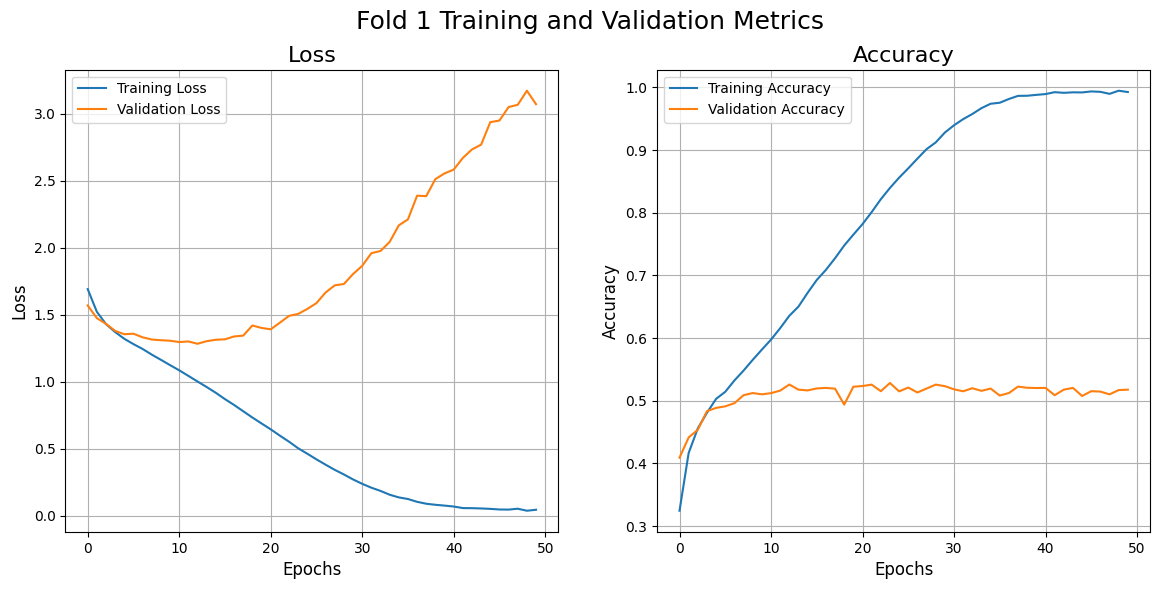

Processing Fold 2...
Train set
3    5768
4    3982
5    3842
2    3305
0    3164
6    2540
1     357
Name: count, dtype: int64
Test set
3    1446
5     987
4     982
0     824
2     792
6     630
1      79
Name: count, dtype: int64
Epoch 1/50


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.2828 - loss: 1.7618 - val_accuracy: 0.3960 - val_loss: 1.5683
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.4164 - loss: 1.5261 - val_accuracy: 0.4300 - val_loss: 1.4784
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.4597 - loss: 1.4293 - val_accuracy: 0.4594 - val_loss: 1.4086
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.4808 - loss: 1.3674 - val_accuracy: 0.4672 - val_loss: 1.3806
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4981 - loss: 1.3170 - val_accuracy: 0.4761 - val_loss: 1.3607
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5206 - loss: 1.2612 - val_accuracy: 0.4866 - val_loss: 1.3422
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5387 - loss: 1.2172 - val_accuracy: 0.4883 - val_loss: 1.3289
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.5594 - loss: 1.1783 - val_accurac

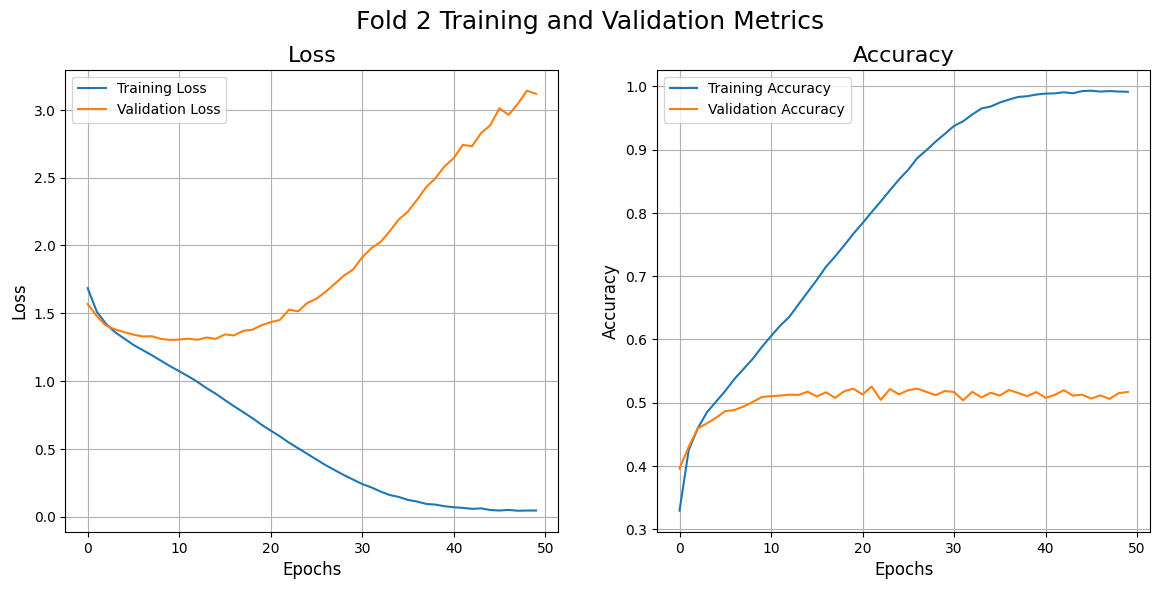

Processing Fold 3...
Train set
3    5768
4    3966
5    3869
2    3252
0    3190
6    2577
1     336
Name: count, dtype: int64
Test set
3    1446
4     998
5     960
2     845
0     798
6     593
1     100
Name: count, dtype: int64
Epoch 1/50


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.2816 - loss: 1.7625 - val_accuracy: 0.3725 - val_loss: 1.6180
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4182 - loss: 1.5347 - val_accuracy: 0.4209 - val_loss: 1.5165
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4500 - loss: 1.4430 - val_accuracy: 0.4415 - val_loss: 1.4575
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.4753 - loss: 1.3805 - val_accuracy: 0.4528 - val_loss: 1.4145
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5012 - loss: 1.3215 - val_accuracy: 0.4693 - val_loss: 1.3774
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5229 - loss: 1.2691 - val_accuracy: 0.4714 - val_loss: 1.3679
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5350 - loss: 1.2330 - val_accuracy: 0.4829 - val_loss: 1.3503
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5527 - loss: 1.1931 - val_accurac

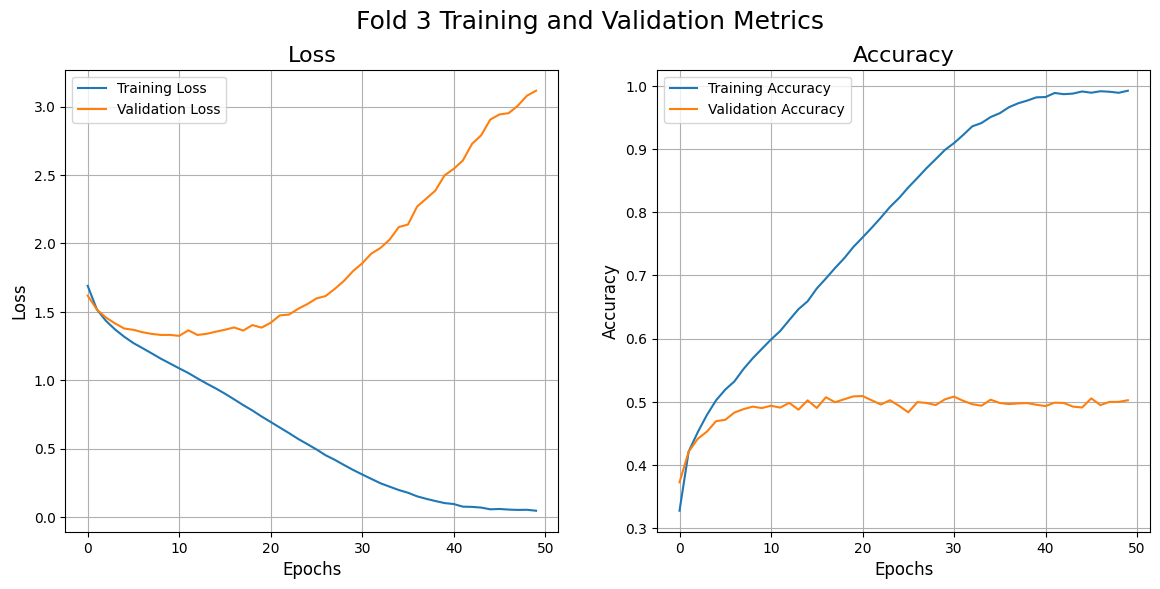

Processing Fold 4...
Train set
3    5767
4    3965
5    3889
2    3285
0    3176
6    2536
1     341
Name: count, dtype: int64
Test set
3    1447
4     999
5     940
0     812
2     812
6     634
1      95
Name: count, dtype: int64
Epoch 1/50


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.2885 - loss: 1.7497 - val_accuracy: 0.3997 - val_loss: 1.5538
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4156 - loss: 1.5214 - val_accuracy: 0.4222 - val_loss: 1.4838
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4677 - loss: 1.4104 - val_accuracy: 0.4564 - val_loss: 1.4111
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4850 - loss: 1.3458 - val_accuracy: 0.4576 - val_loss: 1.3884
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5064 - loss: 1.2979 - val_accuracy: 0.4740 - val_loss: 1.3628
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5223 - loss: 1.2584 - val_accuracy: 0.4759 - val_loss: 1.3598
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5476 - loss: 1.2006 - val_accuracy: 0.4855 - val_loss: 1.3366
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5645 - loss: 1.1753 - val_accurac

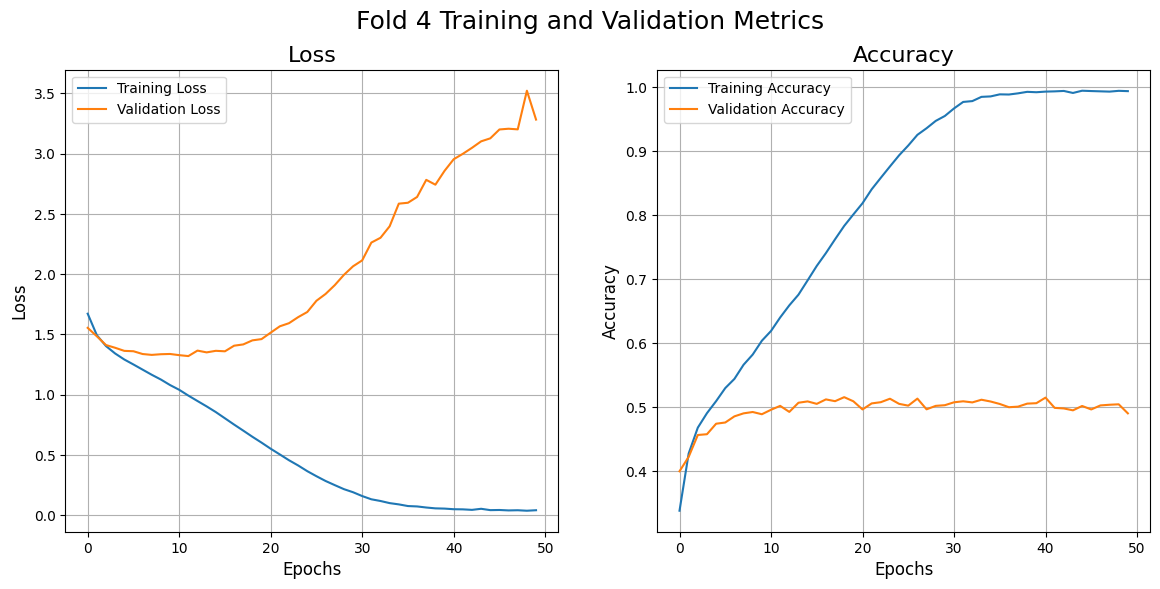

Processing Fold 5...
Train set
3    5814
4    3963
5    3834
2    3281
0    3211
6    2490
1     366
Name: count, dtype: int64
Test set
3    1400
4    1001
5     995
2     816
0     777
6     680
1      70
Name: count, dtype: int64
Epoch 1/50


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.2887 - loss: 1.7484 - val_accuracy: 0.3875 - val_loss: 1.5704
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4185 - loss: 1.5219 - val_accuracy: 0.4358 - val_loss: 1.4761
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4546 - loss: 1.4264 - val_accuracy: 0.4569 - val_loss: 1.4210
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.4788 - loss: 1.3563 - val_accuracy: 0.4605 - val_loss: 1.3973
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5007 - loss: 1.3107 - val_accuracy: 0.4591 - val_loss: 1.4058
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5268 - loss: 1.2571 - val_accuracy: 0.4797 - val_loss: 1.3705
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5390 - loss: 1.2148 - val_accuracy: 0.5044 - val_loss: 1.3470
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5560 - loss: 1.1752 - val_accurac

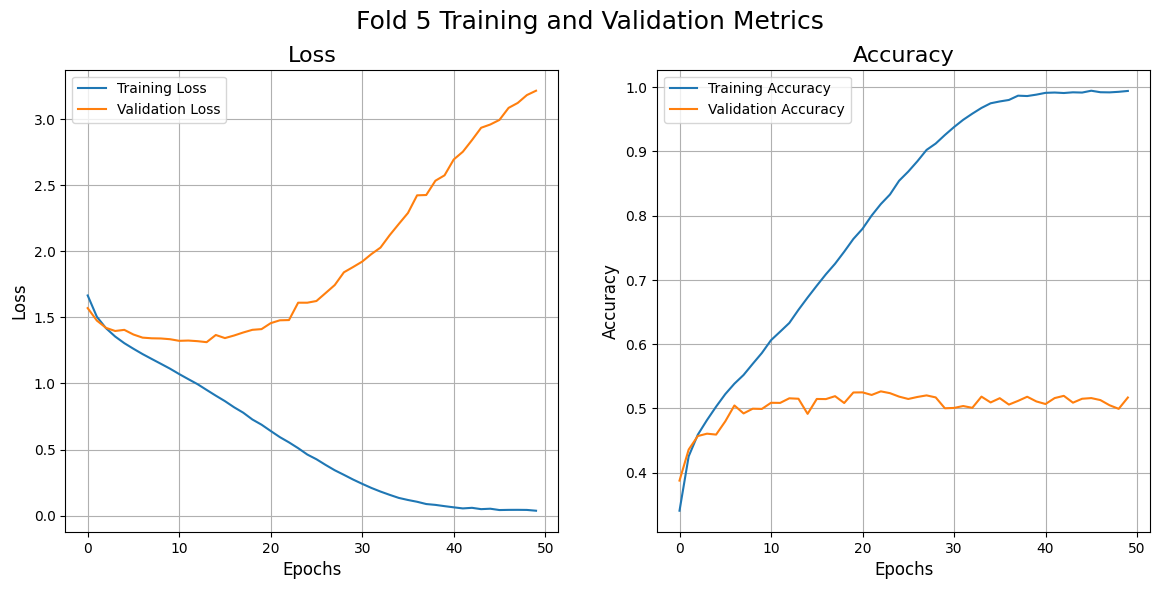


Cross-Validation Results:
Fold 1 Accuracy: 51.76%
Fold 2 Accuracy: 51.69%
Fold 3 Accuracy: 50.24%
Fold 4 Accuracy: 49.02%
Fold 5 Accuracy: 51.68%
Accuracy: 50.88% (+/- 1.09%)


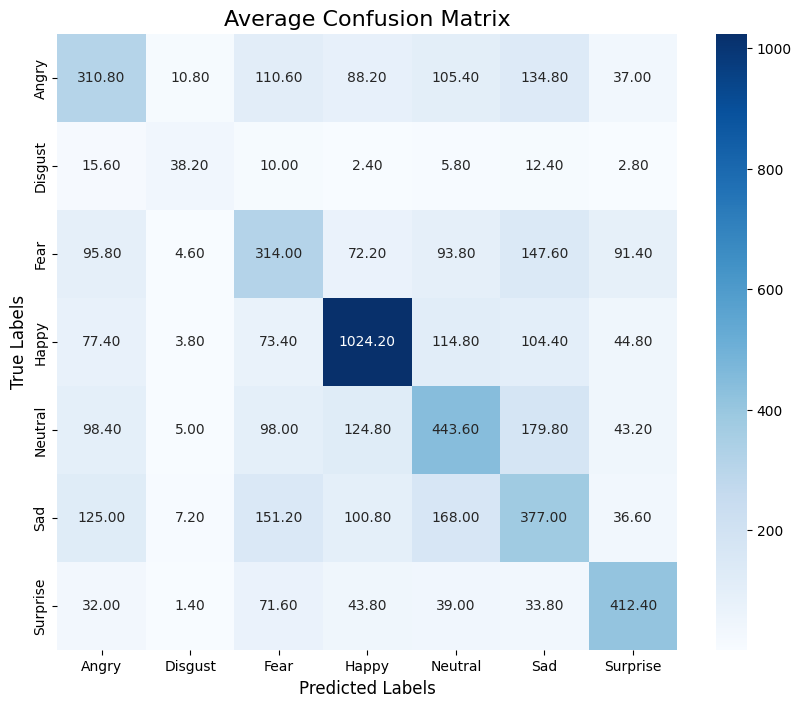


Average Classification Report:
Class    	Precision	Recall   	F1-Score 	Support  
Angry		0.4142		0.3895		0.4002		797.6000
Disgust		0.5435		0.4443		0.4838		87.2000
Fear		0.3793		0.3830		0.3805		819.4000
Happy		0.7048		0.7100		0.7063		1442.8000
Neutral		0.4591		0.4469		0.4517		992.8000
Sad		0.3843		0.3906		0.3857		965.8000
Surprise		0.6244		0.6513		0.6341		634.0000


In [24]:
# Convert one-hot encoded y_train to integer labels
#y_train_int = np.argmax(y_train, axis=1)

# Initialize StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store results
cvscores = []  # Validation accuracy scores
confusion_matrices = []  # Confusion matrices for each fold
# classification_reports = []  # Classification reports for each fold
precision, recall, f1, support = [], [], [], []  # Store metrics for averaging

# Perform Stratified K-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"Processing Fold {fold + 1}...")
    
    # Extract training and testing data for the current fold
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
    #y_train_fold_int = y_train_int[train_idx]

    #show the distribution of emotion for each train and test set
    print("Train set")
    emotion_counts = pd.Series(np.argmax(y_train_fold, axis=1)).value_counts()
    print(emotion_counts)

    print("Test set")
    emotion_counts = pd.Series(np.argmax(y_test_fold, axis=1)).value_counts()
    print(emotion_counts)
    
    # Compute class weights for the current training fold
    # class_weights = compute_class_weight(
    #     class_weight='balanced',
    #     classes=np.unique(y_train_fold_int),
    #     y=y_train_fold_int
    # )
    # class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    # print(f"Class Weights for Fold {fold + 1}: {class_weights_dict}")
    
    # Train the model with the computed class weights
    model = create_model()
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_test_fold, y_test_fold),
        epochs=50,
        batch_size=32,
        verbose=1,
        shuffle=True,
    )
    
    # Evaluate the model on the validation set
    scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    print(f"Fold {fold + 1} Validation Accuracy: {scores[1] * 100:.2f}%")
    cvscores.append(scores[1] * 100)
    
    # Predict and calculate confusion matrix
    y_pred = model.predict(X_test_fold)
    y_pred_int = np.argmax(y_pred, axis=1)  # Convert predictions to integer labels
    y_test_fold_int = np.argmax(y_test_fold, axis=1)
    confusion_matrices.append(confusion_matrix(y_test_fold_int, y_pred_int))
    
    # Calculate classification report and collect metrics for averaging
    report = classification_report(y_test_fold_int, y_pred_int, target_names=EMOTIONS, output_dict=True)
    # classification_reports.append(report)
    
    # Extract precision, recall, f1, and support for averaging
    for key in ['precision', 'recall', 'f1-score', 'support']:
        values = [report[class_name][key] for class_name in EMOTIONS]
        if key == 'precision':
            precision.append(values)
        elif key == 'recall':
            recall.append(values)
        elif key == 'f1-score':
            f1.append(values)
        elif key == 'support':
            support.append(values)

    # Plot training history for the current fold
    plt.figure(figsize=(14, 6))
    plt.suptitle(f'Fold {fold + 1} Training and Validation Metrics', fontsize=18)
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss", fontsize=16)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy", fontsize=16)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Display Cross-Validation Results
print("\nCross-Validation Results:")
for i, score in enumerate(cvscores):
    print(f"Fold {i + 1} Accuracy: {score:.2f}%")
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# Compute and Display Average Confusion Matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)
plt.figure(figsize=(10, 8))
sns.heatmap(
    average_confusion_matrix,
    annot=True,
    fmt='.2f',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS,
    cmap="Blues"
)
plt.title("Average Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()

# Compute and Display Average Classification Report
# Average precision, recall, and f1 across all folds
avg_precision = np.mean(precision, axis=0)
avg_recall = np.mean(recall, axis=0)
avg_f1 = np.mean(f1, axis=0)
avg_support = np.mean(support, axis=0)

# Print Average Classification Report
print("\nAverage Classification Report:")
print("Class    \tPrecision\tRecall   \tF1-Score \tSupport  ")
for i, emotion in enumerate(EMOTIONS):
    print(f"{emotion}\t\t{avg_precision[i]:.4f}\t\t{avg_recall[i]:.4f}\t\t{avg_f1[i]:.4f}\t\t{avg_support[i]:.4f}")


Processing Fold 1...
Train set
3    5772
4    3971
5    3863
2    3277
0    3190
6    2536
1     349
Name: count, dtype: int64
Test set
3    1442
4     993
5     966
2     820
0     798
6     634
1      87
Name: count, dtype: int64
Class Weights for Fold 1: {0: np.float64(1.0281236005373937), 1: np.float64(9.39746213671715), 2: np.float64(1.0008282837089673), 3: np.float64(0.5682110682110683), 4: np.float64(0.8259164658056625), 5: np.float64(0.8490070633482489), 6: np.float64(1.2932627309598919)}
Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.2848 - loss: 1.7628 - val_accuracy: 0.3868 - val_loss: 1.5953
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4075 - loss: 1.5552 - val_accuracy: 0.4300 - val_loss: 1.4957
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4522 - loss: 1.4530 - val_accuracy: 0.4561 - val_loss: 1.4433
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4763 - loss: 1.3944 - val_accuracy: 0.45

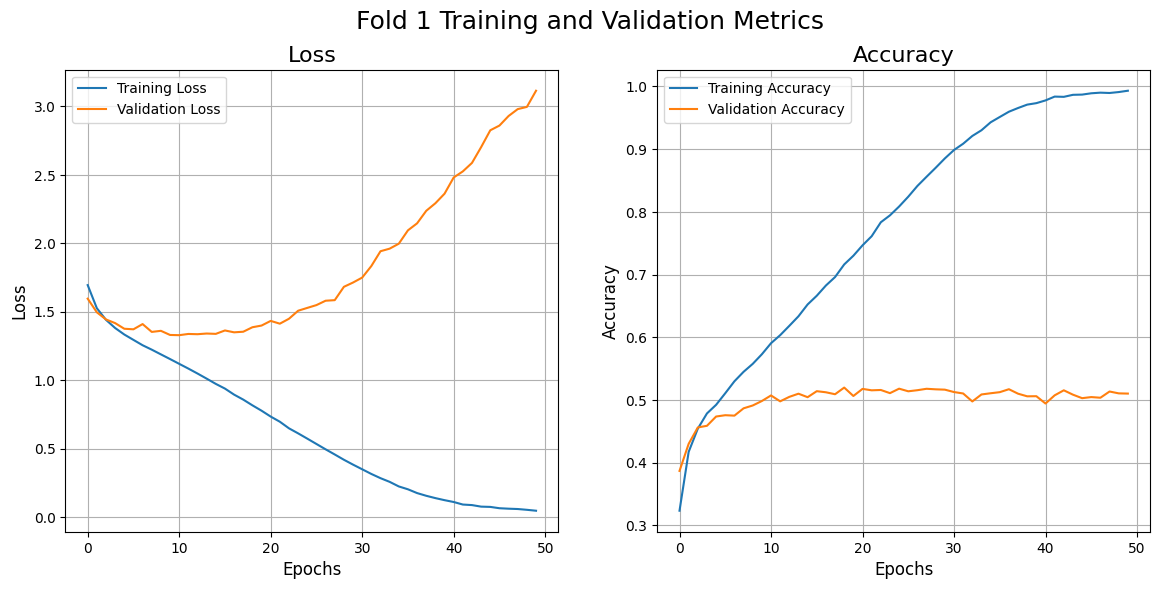

Processing Fold 2...
Train set
3    5771
4    3971
5    3863
2    3278
0    3190
6    2536
1     349
Name: count, dtype: int64
Test set
3    1443
4     993
5     966
2     819
0     798
6     634
1      87
Name: count, dtype: int64
Class Weights for Fold 2: {0: np.float64(1.0281236005373937), 1: np.float64(9.39746213671715), 2: np.float64(1.00052296696592), 3: np.float64(0.5683095279352427), 4: np.float64(0.8259164658056625), 5: np.float64(0.8490070633482489), 6: np.float64(1.2932627309598919)}
Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.8023 - loss: 0.8697 - val_accuracy: 0.9397 - val_loss: 0.2215
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.8755 - loss: 0.4826 - val_accuracy: 0.9425 - val_loss: 0.2105
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.8996 - loss: 0.3728 - val_accuracy: 0.9383 - val_loss: 0.2237
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.9240 - loss: 0.2906 - val_accuracy: 0.9225

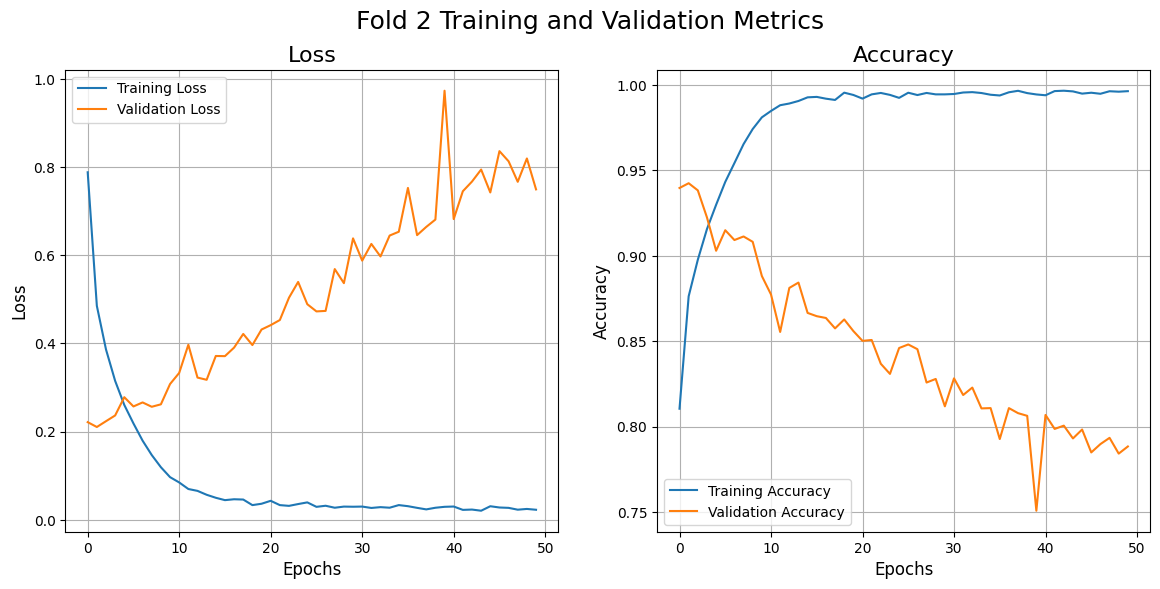

Processing Fold 3...
Train set
3    5771
4    3971
5    3863
2    3278
0    3190
6    2536
1     349
Name: count, dtype: int64
Test set
3    1443
4     993
5     966
2     819
0     798
6     634
1      87
Name: count, dtype: int64
Class Weights for Fold 3: {0: np.float64(1.0281236005373937), 1: np.float64(9.39746213671715), 2: np.float64(1.00052296696592), 3: np.float64(0.5683095279352427), 4: np.float64(0.8259164658056625), 5: np.float64(0.8490070633482489), 6: np.float64(1.2932627309598919)}
Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.9197 - loss: 0.2928 - val_accuracy: 0.9878 - val_loss: 0.0454
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.9774 - loss: 0.0704 - val_accuracy: 0.9902 - val_loss: 0.0361
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.9955 - loss: 0.0253 - val_accuracy: 0.9927 - val_loss: 0.0337
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.9959 - loss: 0.0233 - val_accuracy: 0.9920

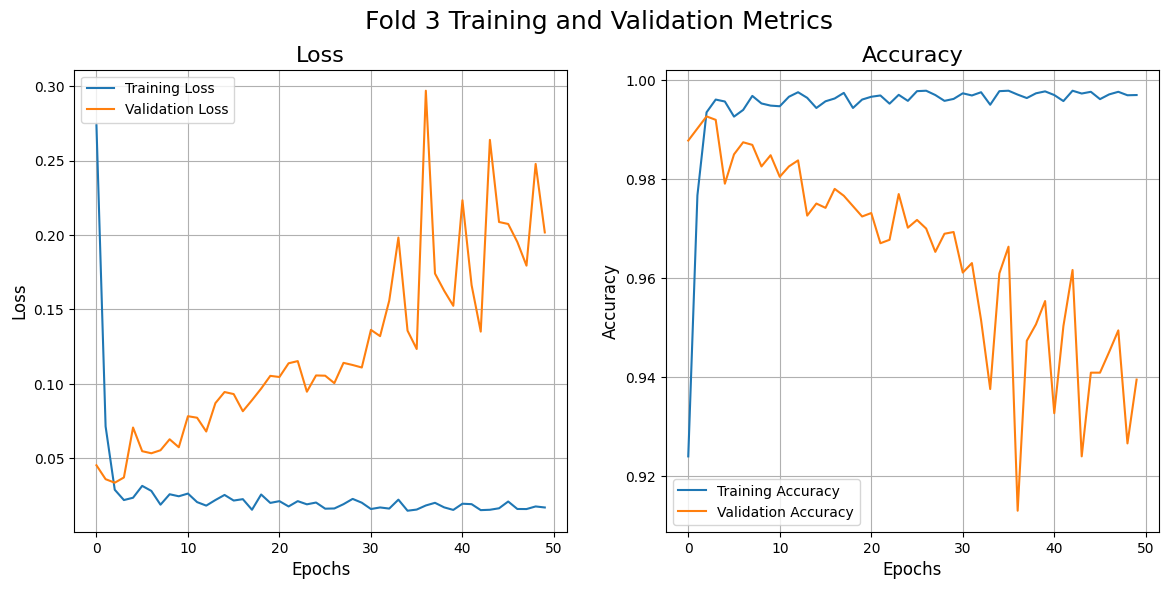

Processing Fold 4...
Train set
3    5771
4    3971
5    3864
2    3278
0    3191
6    2536
1     348
Name: count, dtype: int64
Test set
3    1443
4     993
5     965
2     819
0     797
6     634
1      88
Name: count, dtype: int64
Class Weights for Fold 4: {0: np.float64(1.0278461745086627), 1: np.float64(9.42487684729064), 2: np.float64(1.0005665475464134), 3: np.float64(0.5683342822486819), 4: np.float64(0.8259524409108897), 5: np.float64(0.8488243123336291), 6: np.float64(1.2933190626408293)}
Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.9712 - loss: 0.0957 - val_accuracy: 0.9944 - val_loss: 0.0239
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9937 - loss: 0.0259 - val_accuracy: 0.9974 - val_loss: 0.0123
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9976 - loss: 0.0155 - val_accuracy: 0.9946 - val_loss: 0.0219
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9973 - loss: 0.0170 - val_accuracy: 0.99

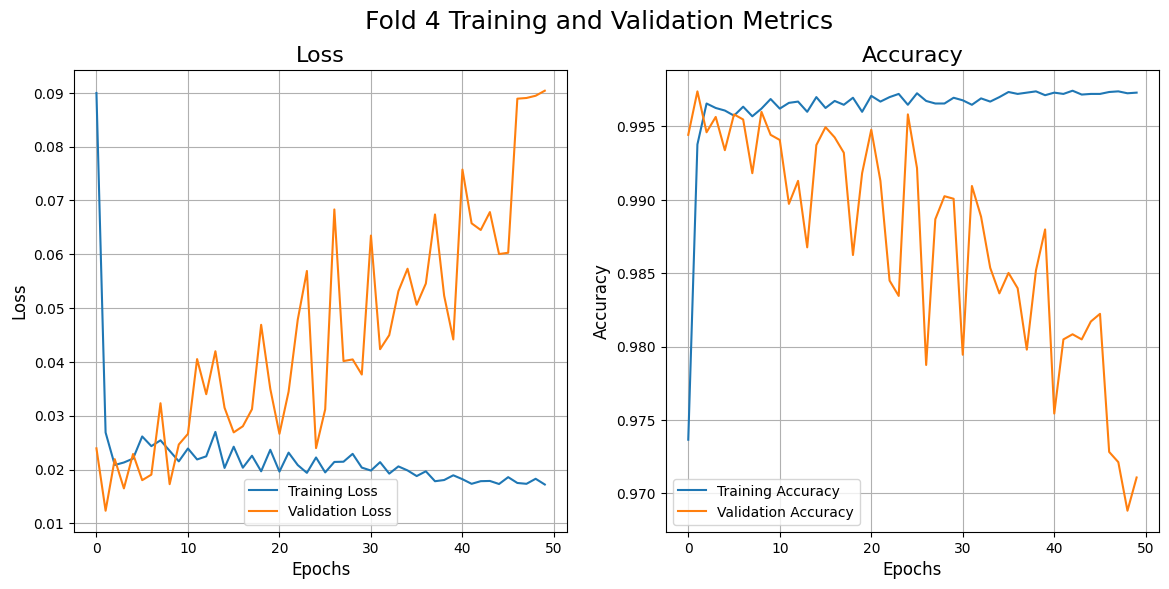

Processing Fold 5...
Train set
3    5771
4    3972
5    3863
2    3277
0    3191
6    2536
1     349
Name: count, dtype: int64
Test set
3    1443
4     992
5     966
2     820
0     797
6     634
1      87
Name: count, dtype: int64
Class Weights for Fold 5: {0: np.float64(1.0278461745086627), 1: np.float64(9.397871469504707), 2: np.float64(1.0008718775883867), 3: np.float64(0.5683342822486819), 4: np.float64(0.8257444971946483), 5: np.float64(0.8490440442291335), 6: np.float64(1.2933190626408293)}
Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.9839 - loss: 0.0536 - val_accuracy: 0.9970 - val_loss: 0.0171
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.9968 - loss: 0.0173 - val_accuracy: 0.9974 - val_loss: 0.0100
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.9979 - loss: 0.0134 - val_accuracy: 0.9976 - val_loss: 0.0111
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.9980 - loss: 0.0094 - val_accuracy: 0.9

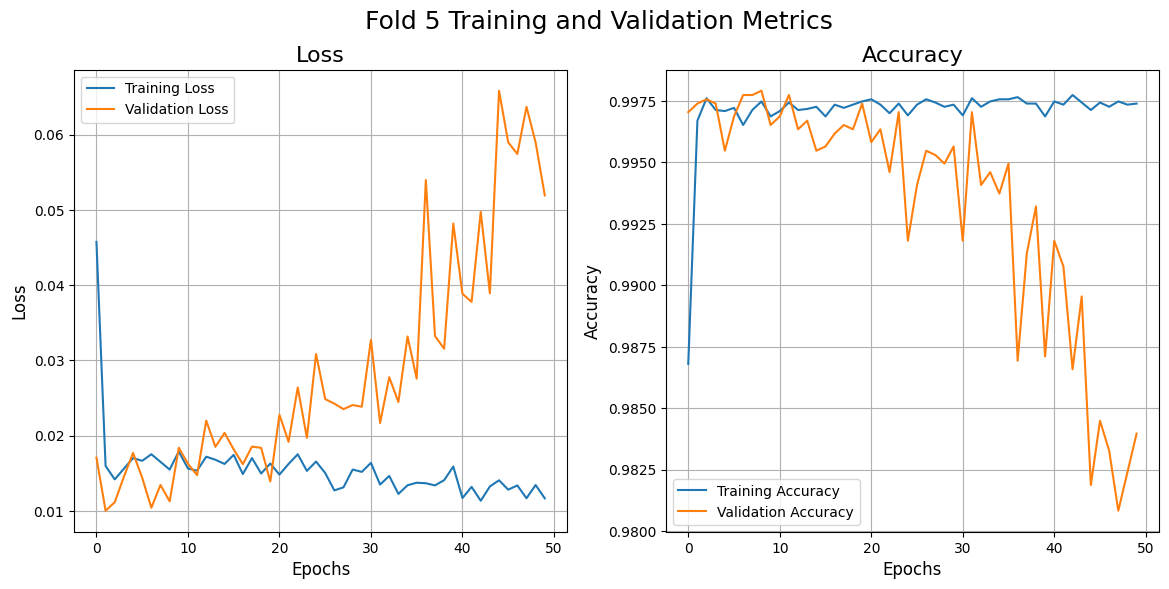


Cross-Validation Results:
Fold 1 Accuracy: 51.01%
Fold 2 Accuracy: 78.83%
Fold 3 Accuracy: 93.95%
Fold 4 Accuracy: 97.11%
Fold 5 Accuracy: 98.40%
Accuracy: 83.86% (+/- 17.85%)


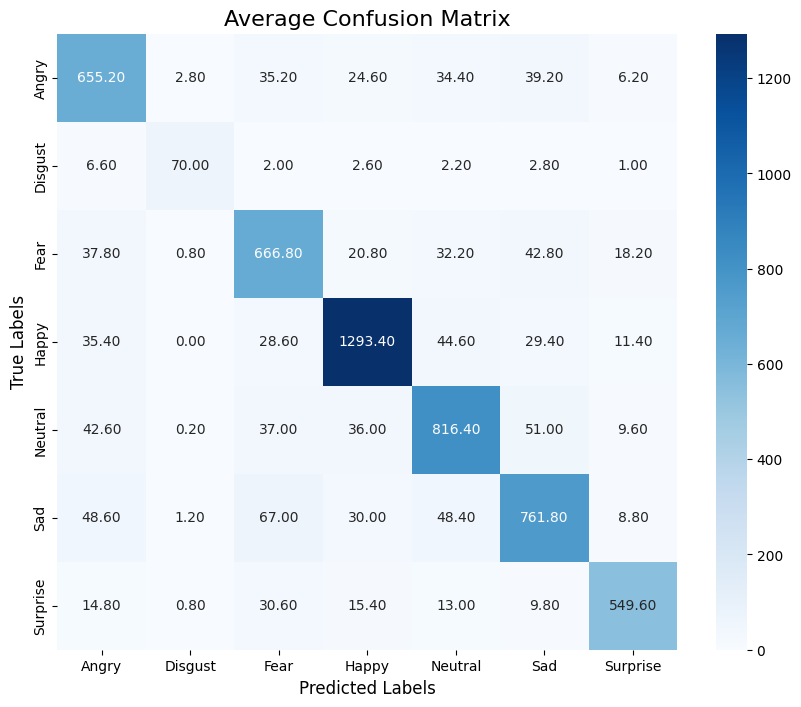


Average Classification Report:
Class    	Precision	Recall   	F1-Score 	Support  
Angry		0.7983		0.8215		0.8087		797.6000
Disgust		0.9040		0.8023		0.8385		87.2000
Fear		0.7726		0.8138		0.7918		819.4000
Happy		0.9110		0.8964		0.9035		1442.8000
Neutral		0.8246		0.8224		0.8230		992.8000
Sad		0.8015		0.7888		0.7945		965.8000
Surprise		0.9035		0.8669		0.8843		634.0000


In [24]:
# Convert one-hot encoded y_train to integer labels
y_train_int = np.argmax(y_train, axis=1)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store results
cvscores = []  # Validation accuracy scores
confusion_matrices = []  # Confusion matrices for each fold
# classification_reports = []  # Classification reports for each fold
precision, recall, f1, support = [], [], [], []  # Store metrics for averaging

# Perform Stratified K-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train_int)):
    print(f"Processing Fold {fold + 1}...")
    
    # Extract training and testing data for the current fold
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
    y_train_fold_int = y_train_int[train_idx]

    #show the distribution of emotion for each train and test set
    print("Train set")
    emotion_counts = pd.Series(np.argmax(y_train_fold, axis=1)).value_counts()
    print(emotion_counts)

    print("Test set")
    emotion_counts = pd.Series(np.argmax(y_test_fold, axis=1)).value_counts()
    print(emotion_counts)
    
    # Compute class weights for the current training fold
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_fold_int),
        y=y_train_fold_int
    )
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    print(f"Class Weights for Fold {fold + 1}: {class_weights_dict}")
    
    # Train the model with the computed class weights
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_test_fold, y_test_fold),
        epochs=50,
        batch_size=32,
        verbose=1,
        shuffle=True,
    )
    
    # Evaluate the model on the validation set
    scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    print(f"Fold {fold + 1} Validation Accuracy: {scores[1] * 100:.2f}%")
    cvscores.append(scores[1] * 100)
    
    # Predict and calculate confusion matrix
    y_pred = model.predict(X_test_fold)
    y_pred_int = np.argmax(y_pred, axis=1)  # Convert predictions to integer labels
    y_test_fold_int = np.argmax(y_test_fold, axis=1)
    confusion_matrices.append(confusion_matrix(y_test_fold_int, y_pred_int))
    
    # Calculate classification report and collect metrics for averaging
    report = classification_report(y_test_fold_int, y_pred_int, target_names=EMOTIONS, output_dict=True)
    # classification_reports.append(report)
    
    # Extract precision, recall, f1, and support for averaging
    for key in ['precision', 'recall', 'f1-score', 'support']:
        values = [report[class_name][key] for class_name in EMOTIONS]
        if key == 'precision':
            precision.append(values)
        elif key == 'recall':
            recall.append(values)
        elif key == 'f1-score':
            f1.append(values)
        elif key == 'support':
            support.append(values)

    # Plot training history for the current fold
    plt.figure(figsize=(14, 6))
    plt.suptitle(f'Fold {fold + 1} Training and Validation Metrics', fontsize=18)
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss", fontsize=16)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # Find the epoch with the minimum validation loss
    # min_val_loss_epoch = np.argmin(history.history['val_loss'])
    # min_val_loss = history.history['val_loss'][min_val_loss_epoch]
    
    # Add a vertical line at the epoch with the minimum validation loss
    # plt.axvline(x=min_val_loss_epoch, color='r', linestyle='--', label=f'Elbow at Epoch {min_val_loss_epoch + 1}')
    # plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy", fontsize=16)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # Find the epoch with the maximum validation accuracy
    # max_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    # max_val_acc = history.history['val_accuracy'][max_val_acc_epoch]
    
    # Add a vertical line at the epoch with the maximum validation accuracy
    # plt.axvline(x=max_val_acc_epoch, color='r', linestyle='--', label=f'Elbow at Epoch {max_val_acc_epoch + 1}')
    # plt.legend()
    
    plt.show()

# Display Cross-Validation Results
print("\nCross-Validation Results:")
for i, score in enumerate(cvscores):
    print(f"Fold {i + 1} Accuracy: {score:.2f}%")
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# Compute and Display Average Confusion Matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)
plt.figure(figsize=(10, 8))
sns.heatmap(
    average_confusion_matrix,
    annot=True,
    fmt='.2f',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS,
    cmap="Blues"
)
plt.title("Average Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()

# Compute and Display Average Classification Report
# Average precision, recall, and f1 across all folds
avg_precision = np.mean(precision, axis=0)
avg_recall = np.mean(recall, axis=0)
avg_f1 = np.mean(f1, axis=0)
avg_support = np.mean(support, axis=0)

# Print Average Classification Report
print("\nAverage Classification Report:")
print("Class    \tPrecision\tRecall   \tF1-Score \tSupport  ")
for i, emotion in enumerate(EMOTIONS):
    print(f"{emotion}\t\t{avg_precision[i]:.4f}\t\t{avg_recall[i]:.4f}\t\t{avg_f1[i]:.4f}\t\t{avg_support[i]:.4f}")


## CNN Modeling

In [43]:
#compute class weights
y_train_int = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train_int),y=y_train_int)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class Weights: {class_weights_dict}")


Class Weights: {0: np.float64(1.0280126092563404), 1: np.float64(9.403014416775884), 2: np.float64(1.0006625056661669), 3: np.float64(0.5682997346429561), 4: np.float64(0.8258892598135145), 5: np.float64(0.8489779013697009), 6: np.float64(1.2932852636322667)}


In [28]:
model = create_model()
history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_data=(X_test, y_test),
    epochs=2,
    verbose=1,
    shuffle=True
)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
897/897 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.2969 - loss: 1.7357 - val_accuracy: 0.4050 - val_loss: 1.5296
Epoch 2/2
897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.4276 - loss: 1.4950 - val_accuracy: 0.4507 - val_loss: 1.4344


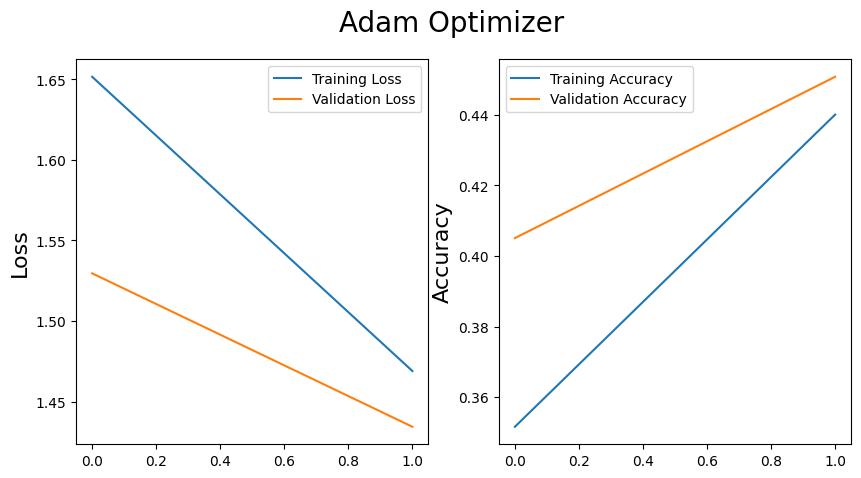

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.suptitle('Adam Optimizer',fontsize=20)
plt.ylabel("Loss",fontsize=16)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.ylabel("Accuracy",fontsize=16)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy')
plt.legend()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


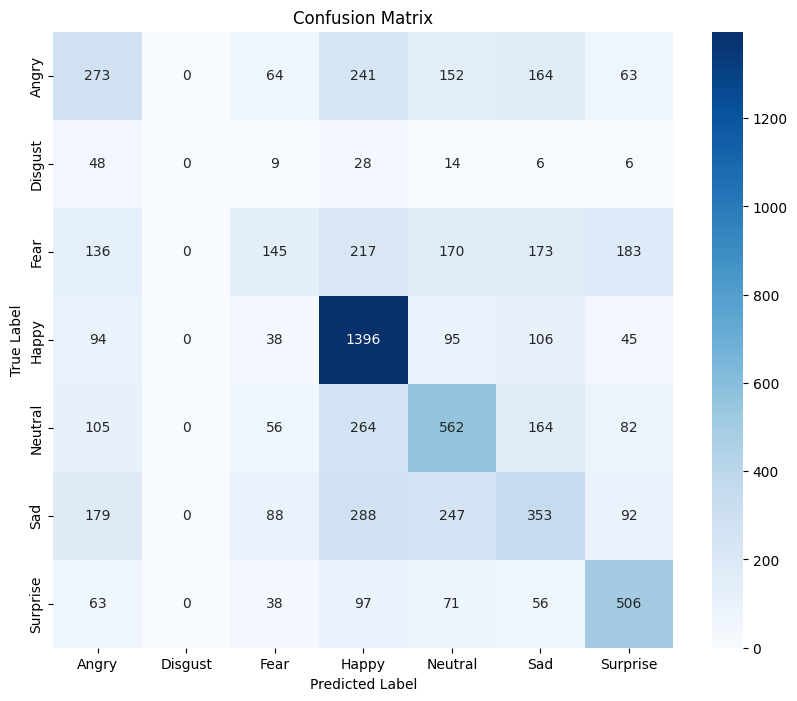

              precision    recall  f1-score   support

       Angry       0.30      0.29      0.29       957
     Disgust       0.00      0.00      0.00       111
        Fear       0.33      0.14      0.20      1024
       Happy       0.55      0.79      0.65      1774
     Neutral       0.43      0.46      0.44      1233
         Sad       0.35      0.28      0.31      1247
    Surprise       0.52      0.61      0.56       831

    accuracy                           0.45      7177
   macro avg       0.35      0.37      0.35      7177
weighted avg       0.42      0.45      0.42      7177



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [30]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(cm, index=EMOTIONS, columns=EMOTIONS)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=EMOTIONS)
print(report)

In [31]:
#save the model
model.save("model.h5")

# Model Test

In [11]:
from Preprocessor import Preprocessor
EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
preprocessor = Preprocessor()
#load model and test
model = tf.keras.models.load_model("Model/model3.h5")



In [27]:

#load the test image
img1, label1 = preprocessor.load_and_process_data("Dataset/FER2013/test/angry/PrivateTest_88305.jpg")
img2, label2 = preprocessor.load_and_process_data("Dataset/FER2013/test/disgust/PrivateTest_807646.jpg")
img3, label3 = preprocessor.load_and_process_data("Dataset/FER2013/test/fear/PrivateTest_134207.jpg")
img4, label4 = preprocessor.load_and_process_data("Dataset/FER2013/test/happy/PrivateTest_95094.jpg")
img5, label5 = preprocessor.load_and_process_data("Dataset/FER2013/test/neutral/PrivateTest_59059.jpg")
img6, label6 = preprocessor.load_and_process_data("Dataset/FER2013/test/sad/PrivateTest_2311869.jpg")
img7, label7 = preprocessor.load_and_process_data("Dataset/FER2013/test/surprise/PrivateTest_104142.jpg")

#predict the image
pred = model.predict(img6)
print(pred)
pred = np.argmax(pred)
print(pred)
print(EMOTIONS[pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[7.6030142e-06 2.3402333e-08 3.6941248e-01 2.5663521e-02 6.0491240e-01
  3.9604110e-06 1.6216954e-10]]
4
Neutral
